In [1]:
import os
import tempfile

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse

from sklearn.utils import check_array
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import utils
import anchor_tabular

In [2]:
# Inverse mapping functions
def _inverse_one_hot(X_onehot, ohc):
    # From https://stackoverflow.com/questions/22548731/
    #   how-to-reverse-sklearn-onehotencoder-transform-to-recover-original-data
    n_samples = X_onehot.shape[0]
    n_features = len(ohc.n_values_)
    # Needed since n_values != 'auto' when trained in LIME/Anchor code
    active_features = np.arange(np.sum(ohc.n_values_)) # All features are active
    X = np.array([
        active_features[col] 
        for col in X_onehot.sorted_indices().indices
    ]).reshape(n_samples, n_features) - ohc.feature_indices_[:-1]
    return X

def _get_disc_to_binary_func(data_row, categorical_features, ordinal_features):
    def _lime_disc_to_binary_mapping(raw_data):
        """raw_data is X_disc and data_row is target instance."""
        # From utils.get_sample_fn(self, data_row, classifier_fn, sample_whole_instances=True, desired_label=None):
        mapping = {}
        for f in categorical_features:
            if f in ordinal_features:
                # I think categorical_names[f] returns a list/dict that maps the bin index
                #  to the ordinal label e.g. "5 <= x < 10" could be a bin name
                for v in range(len(categorical_names[f])): # I think this should be bin number
                    idx = len(mapping)
                    if data_row[f] <= v:
                        mapping[idx] = (f, 'leq', v)
                    elif data_row[f] > v:
                        mapping[idx] = (f, 'geq', v)
            else:
                idx = len(mapping)
                mapping[idx] = (f, 'eq', data_row[f])
        data = np.zeros((raw_data.shape[0], len(mapping)), int)
        for i in mapping:
            f, op, v = mapping[i]
            if op == 'eq':
                data[:, i] = (raw_data[:, f] == data_row[f]).astype(int)
            if op == 'leq':
                data[:, i] = (raw_data[:, f] <= v).astype(int)
            if op == 'geq':
                data[:, i] = (raw_data[:, f] > v).astype(int)
        return data
    return _lime_disc_to_binary_mapping

def _get_unwrap_and_apply(encoder, disc, func):
    """Returns a wrapper that first applies inverse transforms and then applies a function."""
    def _unwrap_and_apply(X_onehot):
        """Invert x_onehot to x_disc to x and then predict given the classifier."""
        # Inverse transform encoder
        #print('One-hot')
        #print(X_onehot)
        X_disc = _inverse_one_hot(X_onehot, encoder)
        #print('Discrete')
        #print(X_disc)
        # Inverse transform discretized x
        X = disc.undiscretize(X_disc)
        #print('Undiscretized (used for predict)')
        #print(X)
        #print('Unique Undiscretized (used for predict)')
        #print(np.unique(X, axis=0))
        # Predict in original space
        return func(X)
    return _unwrap_and_apply

# Simple wrapper to predict for matrix X
def _wrap_for_matrix_input(g):
    def _g_matrix(X):
        X = check_array(X)
        return np.array([g(x) for x in X])
    return _g_matrix



In [3]:
def get_lime_explanation_fn(clf, x_0, disc, explainer_obj):
    """
    Returns a function that takes in a data point (in the ORIGINAL space) that spits out the explanations
    
    params: clf the classifier we want to explain
    params: x_0 the center point
    params: disc the discretization method to use (can be the ones from lime API)
    params: explainer object that is required for lime and anchor explanation
    
    output: a function that takes in a data point (in the ORIGINAL space) that spits out the explanations
    """
    x_0_disc = disc.discretize(x_0)
    # Note we just use predict directly since binary classification
    #  and we want to use for any classifier that has predict method
    def _predict_proba(X):
        """Wrapper that acts like predict_proba but uses predict and only returns 0 or 1."""
        prob = clf.predict(X)
        # Need to return probability matrix instead of vector
        #return prob # Generates error inside LIME (useful for debugging)
        return np.vstack((1-prob, prob)).transpose()
    _unwrap_and_predict_proba = _get_unwrap_and_apply(
        explainer_obj.encoder, disc, _predict_proba)
    explain_fn = utils.get_reduced_explain_fn(
        explainer_obj.explain_lime,
        _unwrap_and_predict_proba,
        num_features=5,
        use_same_dist=True
    )
    exp = explain_fn(x_0_disc)
    intercept = exp['intercept']
    _disc_to_binary = _get_disc_to_binary_func(
        x_0_disc, explainer_obj.categorical_features, explainer_obj.ordinal_features)
    
    def g(x):
        # They actually do a mapping (Anchors code is wrong for ordinal attributes...)
        x_disc = disc.discretize(x)
        # _disc_to_binary takes a matrix and returns a matrix so reshape and select
        x_tilde = _disc_to_binary(x_disc.reshape(1,-1))[0]
        
        weights = []
        for f in exp['as_map']:
            weights.append(exp['as_map'][f])
        scores = np.dot(x_tilde, np.array(weights)) + intercept
        if scores > 0:
            return 1
        else:
            return 0
    return _wrap_for_matrix_input(g)

In [4]:
def get_anchor_explanation_fn(f, x_center, disc, explainer_obj):
    threshold = 0.95 
    _unwrap_and_predict = _get_unwrap_and_apply(explainer_obj.encoder, disc, f.predict)
    explain_fn = utils.get_reduced_explain_fn(
        explainer_obj.explain_lucb_beam,
        _unwrap_and_predict,  # Unwrap and predict using original f
        threshold=threshold,
        delta=0.05,
        tau=0.1,
        batch_size=int(100/2),
        sample_whole_instances=True,
        beam_size=10,
        epsilon_stop=0.05,
    )
    x_center_tilde = disc.discretize(x_center)
    g_tilde = explain_fn(x_center_tilde)
    explanations = [g_tilde]  # Only one explanation
    explanations_data = [x_center_tilde]  # Only one explanation_data
    
    x_center_tilde_onehot = explainer_obj.encoder.transform(x_center_tilde.reshape(-1,2))
    explanation_preds = _unwrap_and_predict(x_center_tilde_onehot)
    
    def g(x):
        x_tilde = disc.discretize(x)
        dataset = x_tilde
   
        # Find the anchors that cover the point
        covered = {}
        for i, (exp, d) in enumerate(zip(explanations, explanations_data)):
            fs = []
            for f, p in zip(exp['feature'], exp['precision']):
                fs.append(f)
                if p >= threshold:
                    break
            fs = np.array(fs)
            # What does this mean?
            #  I think it means if the datapoint is exactly equal?
            covered[i] = set(np.all(dataset[fs] == d[fs]).nonzero()[0])

        # Randomly select an anchor prediction if there is overlap???
        votes = []
        for j in covered:
            if i in covered[j]: # Why is variable `i` here?
                votes.append(explanation_preds[j])
        if votes:
            return np.random.choice(votes)
        else:
            return np.nan
    return _wrap_for_matrix_input(g) 

In [5]:
# Create some data
X, y = make_moons(noise=0.3, random_state=0)
X = StandardScaler().fit_transform(X)
# Train classifier
clf = SVC(gamma=2, C=1).fit(X, y)

In [6]:
# Load the dataset discretized
# The splits for test and training are done inside here
_, temp_path = tempfile.mkstemp(suffix='.csv')
np.savetxt(temp_path, np.hstack((X, y.reshape(-1, 1))), delimiter=',')
dataset = utils.load_csv_dataset(temp_path, 2, feature_names=['x1', 'x2', 'class'], discretize=True)
os.remove(temp_path) # Clean up temp file

# Define the explainer object that the anchor and lime will use
#  How does this use dataset.data? Maybe replace with dummies?
explainer_obj = anchor_tabular.AnchorTabularExplainer(
    dataset.class_names, dataset.feature_names, dataset.data, dataset.categorical_names
)
#  How does this use dataset.train, dataset.validation? Maybe replace with dummies?
explainer_obj.fit(
    dataset.train, dataset.labels_train, dataset.validation, dataset.labels_validation
)

# Get explanations
x_0  = np.array([-.5, 0.5])
g_lime = get_lime_explanation_fn(clf, x_0, dataset.disc, explainer_obj)
g_anchor = get_anchor_explanation_fn(clf, x_0, dataset.disc, explainer_obj)

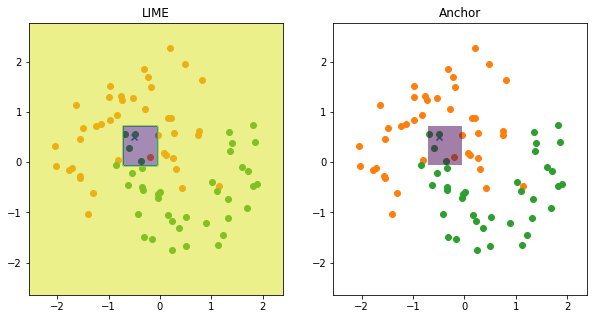

In [7]:
# Visualize decision boundaries
h = 0.02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
def _get_Z(g):
    # Compute explanations
    Z = g(np.c_[xx.ravel(), yy.ravel()])

    #Z[np.isnan(Z)] == 2
    Z = np.ma.masked_array(Z)
    Z = Z.reshape(xx.shape)
    Z = (Z - 0.5)/0.5 # Scale to between -1 and 1 so 0 is white
    return Z
Z_lime = _get_Z(g_lime)
Z_anchor = _get_Z(g_anchor)

_, axes = plt.subplots(1, 2, figsize=(10,5))
for Z, ax, title  in zip([Z_lime, Z_anchor], axes.ravel(), ['LIME', 'Anchor'] ):
    ax.scatter(x_0[0], x_0[1], marker='x')
    ax.scatter(X[dataset.train_idx[y[dataset.train_idx]==0],0], X[dataset.train_idx[y[dataset.train_idx]==0],1])
    ax.scatter(X[dataset.train_idx[y[dataset.train_idx]==1],0], X[dataset.train_idx[y[dataset.train_idx]==1],1])
    #plt.scatter(X[dataset.train_idx,0], X[dataset.train_idx,1], c=y[dataset.train_idx])
    # Set vmin and vmax so scaling isn't automatic
    ax.contourf(xx, yy, Z, norm=None, vmin=-1, vmax=1, alpha=.5)
    ax.set_title(title)
plt.show()